In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from datetime import datetime
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import sparse
from scipy.sparse import csc_matrix
from sklearn.decomposition import TruncatedSVD
import random
random.seed(0)
np.random.seed(0)

## Analyse Dataset

In [ ]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!gdown https://drive.google.com/uc?id=1ccoCOvxD2hFm1ejOVRDlT2SivkoNtC6V

Downloading...
From: https://drive.google.com/uc?id=1ccoCOvxD2hFm1ejOVRDlT2SivkoNtC6V
To: /content/ml-100k.zip
100% 4.92M/4.92M [00:00<00:00, 162MB/s]


In [ ]:
!unzip "ml-100k.zip"  -d  "/content"
!mv ml-100k/* ./

Archive:  ml-100k.zip
  inflating: /content/ml-100k/allbut.pl  
  inflating: /content/ml-100k/mku.sh  
  inflating: /content/ml-100k/README  
  inflating: /content/ml-100k/u.data  
  inflating: /content/ml-100k/u.genre  
  inflating: /content/ml-100k/u.info  
  inflating: /content/ml-100k/u.item  
  inflating: /content/ml-100k/u.occupation  
  inflating: /content/ml-100k/u.user  
  inflating: /content/ml-100k/u1.base  
  inflating: /content/ml-100k/u1.test  
  inflating: /content/ml-100k/u2.base  
  inflating: /content/ml-100k/u2.test  
  inflating: /content/ml-100k/u3.base  
  inflating: /content/ml-100k/u3.test  
  inflating: /content/ml-100k/u4.base  
  inflating: /content/ml-100k/u4.test  
  inflating: /content/ml-100k/u5.base  
  inflating: /content/ml-100k/u5.test  
  inflating: /content/ml-100k/ua.base  
  inflating: /content/ml-100k/ua.test  
  inflating: /content/ml-100k/ub.base  
  inflating: /content/ml-100k/ub.test  


In [ ]:
dateparse = lambda x: datetime.utcfromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S')

rating_df = pd.read_csv('u.data', sep='\t', 
                        names=['userID', 'itemID', 'rating', 'time'], 
                       )

movie_df = pd.read_csv('u.item', sep='|', encoding='latin-1',
                    names=['itemID', 'movie', 'release_date', 'video_release_date', 'imdb_url', 'unknown', 'action', 
                           'adventure', 'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 
                           'film_noir', 'horror', 'musical', 'mystery', 'romance', 'sci_fi', 'thriller', 'war', 'western'])

user_df = pd.read_csv('u.user', sep='|', encoding='latin-1',
                     names=['userID', 'age', 'gender', 'occupation', 'zip_code'])


In [ ]:
rating_df=pd.merge(rating_df,movie_df,on="itemID",how="left")


In [ ]:

rating_df["itemID"] = rating_df["itemID"].astype(str)
rating_df["userID"] = rating_df["userID"].astype(str)

In [ ]:
unique_users = rating_df.userID.unique()
user_ids = dict(zip(unique_users, np.arange(unique_users.shape[0], dtype=np.int32)))

unique_items = rating_df.itemID.unique()
item_ids = dict(zip(unique_items, np.arange(unique_items.shape[0], dtype=np.int32)))

In [ ]:
product_ids = list(set(list(rating_df.itemID.unique())))
user_ids = list(set(list(rating_df.userID.unique())))

#### Consider movies rated by more than 200 users

In [ ]:

rating_df=rating_df[['userID','itemID','rating']]

y = rating_df.groupby('itemID').count()['rating']>=50
items = y[y].index
rating_df = rating_df[rating_df['itemID'].isin(items)]
rating_df.shape

x = rating_df.groupby('userID').count()['rating'] >= 30
userIndex = x[x].index
rating_df=rating_df[rating_df['userID'].isin(userIndex)]


In [ ]:
rating_df=rating_df.astype(int)

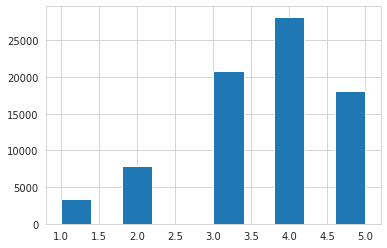

In [ ]:
rating_df['rating'].hist()

In [ ]:
rating_df.shape

(78445, 3)

## Light GCN

#### Install packages

In [ ]:
!pip install recommenders

In [ ]:
from recommenders.utils.timer import Timer
from recommenders.models.deeprec.models.graphrec.lightgcn import LightGCN
from recommenders.models.deeprec.DataModel.ImplicitCF import ImplicitCF
from recommenders.datasets import movielens
from recommenders.datasets.python_splitters import python_stratified_split
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.utils.constants import SEED as DEFAULT_SEED
from recommenders.models.deeprec.deeprec_utils import prepare_hparams

In [ ]:
train, test = python_stratified_split(rating_df, ratio=0.8)

Process data

In [ ]:
SEED=42
# top k items to recommend
TOP_K = 20

# Model parameters
EPOCHS = 100
BATCH_SIZE = 1000

In [ ]:

data = ImplicitCF(train=train, test=test, seed=SEED)

Prepare hyper-parameters

In [ ]:
# #model
# model:
#     model_type : "lightgcn"
#     embed_size : 64 # the embedding dimension of users and items
#     n_layers : 3 # number of layers of the model
    
# #train
# train:
#     batch_size : 1024
#     decay : 0.0001 # l2 regularization for embedding parameters
#     epochs : 1000 # number of epochs for training
#     learning_rate : 0.001
#     eval_epoch : -1 # if it is not -1, evaluate the model every eval_epoch; -1 means that evaluation will not be performed during training
#     top_k : 20 # number of items to recommend when calculating evaluation metrics

# #show info
# #metric : "recall", "ndcg", "precision", "map"
# info:
#     save_model : False # whether to save model
#     save_epoch : 100 # if save_model is set to True, save the model every save_epoch
#     metrics : ["recall", "ndcg", "precision", "map"] # metrics for evaluation
#     MODEL_DIR : ./tests/resources/deeprec/lightgcn/model/lightgcn_model/ # directory of saved models

In [ ]:
yaml_file = "param.yaml"
hparams = prepare_hparams(yaml_file,
                          n_layers=4,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          learning_rate=0.005,
                          eval_epoch=5,
                          top_k=TOP_K,
                         )

In [ ]:

model = LightGCN(hparams, data, seed=SEED)

Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.


Recommendation

In [ ]:
with Timer() as train_time:
    model.fit()

print("Took {} seconds for training.".format(train_time.interval))

Epoch 1 (train)1.3s: train loss = 0.62717 = (mf)0.62701 + (embed)0.00017
Epoch 2 (train)0.7s: train loss = 0.51728 = (mf)0.51673 + (embed)0.00056
Epoch 3 (train)0.7s: train loss = 0.45468 = (mf)0.45378 + (embed)0.00090
Epoch 4 (train)0.7s: train loss = 0.43067 = (mf)0.42946 + (embed)0.00120
Epoch 5 (train)0.7s + (eval)1.8s: train loss = 0.41778 = (mf)0.41637 + (embed)0.00141, recall = 0.26385, ndcg = 0.34541, precision = 0.26218, map = 0.13095
Epoch 6 (train)0.7s: train loss = 0.39580 = (mf)0.39417 + (embed)0.00163
Epoch 7 (train)0.7s: train loss = 0.37721 = (mf)0.37531 + (embed)0.00190
Epoch 8 (train)0.7s: train loss = 0.36512 = (mf)0.36296 + (embed)0.00216
Epoch 9 (train)0.7s: train loss = 0.35828 = (mf)0.35590 + (embed)0.00238
Epoch 10 (train)0.7s + (eval)0.2s: train loss = 0.35210 = (mf)0.34952 + (embed)0.00258, recall = 0.29735, ndcg = 0.38952, precision = 0.29423, map = 0.15767
Epoch 11 (train)0.7s: train loss = 0.34376 = (mf)0.34099 + (embed)0.00277
Epoch 12 (train)0.7s: train l

In [ ]:
topk_scores = model.recommend_k_items(test, top_k=TOP_K, remove_seen=True)

topk_scores.head()

,userID,itemID,prediction
0,1,144,3.796903
1,1,7,3.479088
2,1,455,3.338653
3,1,172,3.322329
4,1,475,3.302534


Evaluation

In [ ]:
eval_map = map_at_k(test, topk_scores, k=TOP_K)
eval_ndcg = ndcg_at_k(test, topk_scores, k=TOP_K)
eval_precision = precision_at_k(test, topk_scores, k=TOP_K)
eval_recall = recall_at_k(test, topk_scores, k=TOP_K)

In [ ]:
# Record results with papermill for tests
print("map"+ str(eval_map))
print("ndcg"+ str(eval_ndcg))
print("precision"+ str( eval_precision))
print("recall"+ str(eval_recall))

map0.18944830600425114
ndcg0.4362813457268996
precision0.32770655270655275
recall0.339746673422096
